<a href="https://colab.research.google.com/github/Armel21/Coursera_Capstone_Project/blob/master/Bienvenue_dans_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bienvenue dans Colab !

## Google Colab est disponible dans VS Code !
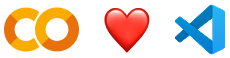

Essayez la nouvelle <a href="https://marketplace.visualstudio.com/items?itemName=Google.colab">extension Google Colab</a> pour Visual Studio Code. Vous pouvez vous lancer en quelques clics :

*  Dans VS Code, ouvrez la vue <strong><em>Extensions</em></strong> et recherchez "Google Colab" pour l'installer.
*  Ouvrez le sélecteur de kernel en créant ou en ouvrant un fichier de notebook <code>.ipynb</code> dans votre espace de travail local, puis en exécutant une cellule ou en cliquant sur le bouton <strong><em>Select Kernel</em></strong> &#40;Sélectionner le kernel&#41; en haut à droite.
*  Cliquez sur <strong><em>Colab</em></strong>, puis sélectionnez l'environnement d'exécution souhaité et connectez-vous avec votre compte Google. C'est tout !

Pour en savoir plus, consultez l'<a href="https://developers.googleblog.com/google-colab-is-coming-to-vs-code">annonce sur notre blog</a>.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import io
import itertools
from numpy.linalg import inv

from itertools import combinations
from scipy.optimize import minimize
from numpy.linalg import inv


In [45]:
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/48_Industry_Portfolios_CSV.zip"

response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))

print("Contenu du ZIP :")
for name in z.namelist():
    print(name)


Contenu du ZIP :
48_Industry_Portfolios.csv


In [47]:
raw = z.read("48_Industry_Portfolios.csv").decode("latin1", errors="replace")

print("FIRST 50 LINES OF YOUR FILE:")
for i, line in enumerate(raw.split("\n")[:15]):
    print(f"{i:02d}: {line}")


FIRST 50 LINES OF YOUR FILE:
00: This file was created using the 202512 CRSP database.
01: It contains value- and equal-weighted returns for 48 industry portfolios.
02: 
03: The portfolios are constructed at the end of June.
04: 
05: The annual returns are from January to December.
06: 
07: Missing data are indicated by -99.99 or -999.
08: 
09: 
10:   Average Value Weighted Returns -- Monthly
11: ,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,Hlth,MedEq,Drugs,Chems,Rubbr,Txtls,BldMt,Cnstr,Steel,FabPr,Mach,ElcEq,Autos,Aero,Ships,Guns,Gold,Mines,Coal,Oil,Util,Telcm,PerSv,BusSv,Comps,Chips,LabEq,Paper,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
12: 192607,   2.36,   0.09, -99.99,  -5.19,   1.29,   8.65,   2.49,  50.21,  -0.49,   8.08, -99.99,   5.33,   0.90,   8.16, -99.99,   0.50,   2.48,  -8.21,   4.06, -99.99,   5.44,   3.18,  14.56,  -0.65,   1.13, -99.99, -99.99,   5.64,   1.48,  -1.35,   7.04,   0.83, -99.99,   5.91,   3.63,   1.33,   1.35, -99.99,   7.70,   1.

In [48]:
print("="*80)
print("LOADING 48 INDUSTRIES DATA (LAST 5 YEARS)")
print("="*80)

# ------------------------------------------------------------
# 1. Download ZIP
# ------------------------------------------------------------
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/48_Industry_Portfolios_CSV.zip"
response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))

# Extract CSV content
csv_name = "48_Industry_Portfolios.csv"
raw = z.read(csv_name).decode("latin1")
lines = raw.split("\n")

# ------------------------------------------------------------
# 2. Identify header row (line starting with ",Agric")
# ------------------------------------------------------------
header_idx = None
for i, line in enumerate(lines):
    if line.startswith(",Agric"):
        header_idx = i
        break

# ------------------------------------------------------------
# 3. Identify end of monthly section ("Annual")
# ------------------------------------------------------------
end_idx = None
for i, line in enumerate(lines):
    if "Annual" in line:
        end_idx = i
        break

# ------------------------------------------------------------
# 4. Extract monthly block
# ------------------------------------------------------------
monthly_block = "\n".join(lines[header_idx:end_idx])

# ------------------------------------------------------------
# 5. Load CSV normally (comma-separated)
# ------------------------------------------------------------
df = pd.read_csv(io.StringIO(monthly_block))

# First column is the date
df.rename(columns={df.columns[0]: "Date"}, inplace=True)

# Keep only YYYYMM rows
df = df[df["Date"].astype(str).str.len() == 6]

# Convert to datetime
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m")
df.set_index("Date", inplace=True)

# Convert % to decimals
df = df.apply(pd.to_numeric, errors="coerce") / 100

print("Data loaded successfully!")
print("Shape:", df.shape)
print("Industries:", list(df.columns))


LOADING 48 INDUSTRIES DATA (LAST 5 YEARS)
Data loaded successfully!
Shape: (2388, 48)
Industries: ['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero', 'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin', 'Other']


In [49]:
# df contient déjà les 48 industries en décimal, index = Date (mensuel)

print("\nFILTERING LAST 5 YEARS")
print("-"*80)

# 1. Extraire les 5 dernières années (comme en R avec cutoff)
today = pd.Timestamp.today()
cutoff = pd.Timestamp(today.year - 5, 1, 1)

df5 = df[df.index >= cutoff].copy()

print(f"Date range: {df5.index.min().strftime('%Y-%m')} → {df5.index.max().strftime('%Y-%m')}")
print(f"Number of months: {len(df5)}")

# 2. Noms des industries
industry_names = list(df5.columns)

# 3. S’assurer que tout est bien numérique (sécurité)
df5[industry_names] = df5[industry_names].apply(pd.to_numeric, errors="coerce")

# 4. Équivalent de ton xts Data en R
Data = df5.copy()   # DataFrame index = Date, colonnes = industries

print("\nData (last 5 years) shape:", Data.shape)
print("Industries:", industry_names)
print("\nHead:")
print(Data.head())



FILTERING LAST 5 YEARS
--------------------------------------------------------------------------------
Date range: 2021-01 → 2025-12
Number of months: 120

Data (last 5 years) shape: (120, 48)
Industries: ['Agric', 'Food', 'Soda', 'Beer', 'Smoke', 'Toys', 'Fun', 'Books', 'Hshld', 'Clths', 'Hlth', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls', 'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach', 'ElcEq', 'Autos', 'Aero', 'Ships', 'Guns', 'Gold', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'PerSv', 'BusSv', 'Comps', 'Chips', 'LabEq', 'Paper', 'Boxes', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin', 'Other']

Head:
             Agric    Food    Soda    Beer   Smoke    Toys     Fun   Books  \
Date                                                                         
2021-01-01  0.0248 -0.0131 -0.0963 -0.0688 -0.0228  0.0575 -0.0388  0.0414   
2021-02-01  0.1239 -0.0005  0.0067 -0.0333  0.0573 -0.0247  0.1073  0.1366   
2021-03-01  0.0335  0.0802  0.0718  0.0841  0.1173 -0.0780

B3 Méthode exhaustive indirecte :
------------------------------

Cette méthode consiste à tester exhaustivement toutes les combinaisons possibles
d’industries jusqu’à une taille maximale (par exemple 5 actifs). Pour chaque
sous-ensemble, nous calculons le portefeuille tangent (max Sharpe), puis nous évaluons son ratio de Sharpe.

La combinaison d’industries qui maximise le Sharpe est retenue comme solution exhaustive indirecte. Cette approche est dite "indirecte" car nous ne résolvons pas un problème d’optimisation complexe : nous utilisons la solution analytique
du portefeuille tangent pour chaque sous-ensemble.

Étapes :
1. Générer toutes les combinaisons d’industries de taille 1 à k_max.
2. Pour chaque combinaison :
   - extraire μ_S et Σ_S
   - calculer w* = Σ_S^{-1} μ_S / (1' Σ_S^{-1} μ_S)
   - calculer le Sharpe du portefeuille
3. Retenir la combinaison qui maximise le Sharpe.





In [51]:
print("="*80)
print("TOP 15 INDUSTRIES PAR SHARPE (SANS IC)")
print("="*80)

# 1. Statistiques de base
mean_returns = Data.mean(axis=0)
std_returns = Data.std(axis=0)

# 2. Sharpe ratio (sans IC)
sharpe = (mean_returns - risk_free_rate) / std_returns

# 3. Tableau trié
sharpe_table = pd.DataFrame({
    "Mean": mean_returns,
    "Std": std_returns,
    "Sharpe": sharpe
}).sort_values("Sharpe", ascending=False)

# 4. Affichage des 15 meilleures industries
top15 = sharpe_table.head(15)
display(top15)

print("\nNombre d'industries affichées :", top15.shape[0])
print("="*80)


TOP 15 INDUSTRIES PAR SHARPE (SANS IC)


,Mean,Std,Sharpe
Coal,0.045227,0.123730,0.108516
Steel,0.026938,0.092788,-0.052404
Gold,0.022373,0.139458,-0.067595
FabPr,0.018865,0.104779,-0.123451
Oil,0.020436,0.088755,-0.128039
Cnstr,0.019165,0.081506,-0.155020
Aero,0.018682,0.083754,-0.156629
Guns,0.016008,0.093866,-0.168246
Mines,0.017397,0.080706,-0.178466
Chips,0.016018,0.075329,-0.209513



Nombre d'industries affichées : 15


Ici nous venons de selectionner les 15 industries ayant un mailleur ratio de sharpe.

In [35]:


print("="*80)
print("RECHERCHE EXHAUSTIVE SUR LES 15 MEILLEURES INDUSTRIES")
print("="*80)

# ------------------------------------------------------------
# 1. Sous-ensemble : les 15 industries sélectionnées
# ------------------------------------------------------------
selected_industries = top15.index.tolist()
rets15 = Data[selected_industries]

T, K = rets15.shape
industries15 = rets15.columns

mu = rets15.mean().values
Sigma = rets15.cov().values

# ------------------------------------------------------------
# 2. Fonctions utilitaires
# ------------------------------------------------------------
def tangent_portfolio(mu_S, Sigma_S, rf, short_selling=True):
    ones = np.ones(len(mu_S))
    Sigma_inv = inv(Sigma_S)
    w = Sigma_inv @ (mu_S - rf * ones)
    w = w / np.sum(w)

    if not short_selling:
        w = np.maximum(w, 0)
        if w.sum() == 0:
            return None
        w = w / w.sum()

    return w

def sharpe_ratio(w, mu_S, Sigma_S, rf):
    ret = w @ mu_S
    risk = np.sqrt(w @ Sigma_S @ w)
    return (ret - rf) / risk

# ------------------------------------------------------------
# 3. Recherche exhaustive 1 à 5 industries
# ------------------------------------------------------------
best_short = None
best_noshort = None

for k in range(1, 6):
    for subset in itertools.combinations(industries15, k):

        idx = [industries15.get_loc(i) for i in subset]

        mu_S = mu[idx]
        Sigma_S = Sigma[np.ix_(idx, idx)]

        # ----- Cas 1 : avec short-selling -----
        w_fs = tangent_portfolio(mu_S, Sigma_S, risk_free_rate, short_selling=True)
        S_fs = sharpe_ratio(w_fs, mu_S, Sigma_S, risk_free_rate)

        if (best_short is None) or (S_fs > best_short["Sharpe"]):
            best_short = {
                "industries": subset,
                "weights": w_fs,
                "Sharpe": S_fs,
                "k": k
            }

        # ----- Cas 2 : sans short-selling -----
        w_ns = tangent_portfolio(mu_S, Sigma_S, risk_free_rate, short_selling=False)
        if w_ns is not None:
            S_ns = sharpe_ratio(w_ns, mu_S, Sigma_S, risk_free_rate)

            if (best_noshort is None) or (S_ns > best_noshort["Sharpe"]):
                best_noshort = {
                    "industries": subset,
                    "weights": w_ns,
                    "Sharpe": S_ns,
                    "k": k
                }

# ------------------------------------------------------------
# 4. Résultats finaux
# ------------------------------------------------------------
print("\n=== Portefeuille optimal AVEC short-selling ===")
print("Industries :", best_short["industries"])
print("Nombre d'industries :", best_short["k"])
print("Poids :", best_short["weights"])
print("Sharpe :", best_short["Sharpe"])

print("\n=== Portefeuille optimal SANS short-selling ===")
print("Industries :", best_noshort["industries"])
print("Nombre d'industries :", best_noshort["k"])
print("Poids :", best_noshort["weights"])
print("Sharpe :", best_noshort["Sharpe"])

print("="*80)


RECHERCHE EXHAUSTIVE SUR LES 15 MEILLEURES INDUSTRIES

=== Portefeuille optimal AVEC short-selling ===
Industries : ('Coal', 'Gold')
Nombre d'industries : 2
Poids : [ 3.13072478 -2.13072478]
Sharpe : 0.14859198908271262

=== Portefeuille optimal SANS short-selling ===
Industries : ('Coal',)
Nombre d'industries : 1
Poids : [1.]
Sharpe : 0.10851581630506316



GREEDY FORWARD SELECTION (GFS) SUR LES 48 INDUSTRIES
----------------------------------------------------

La méthode GFS est une procédure d’allocation séquentielle qui construit
un portefeuille en ajoutant les industries une par une, de manière
"gloutonne" (greedy). À chaque étape, on choisit l’industrie qui
améliore le plus le ratio de Sharpe du portefeuille courant.

Contrairement à l’exhaustive search, GFS ne teste pas toutes les
combinaisons possibles : elle explore seulement un chemin séquentiel,
ce qui la rend beaucoup plus rapide tout en restant efficace.



Utilité : Méthode rapide et performante pour sélectionner un sous-ensemble d’industries.



In [38]:
print("="*80)
print("GREEDY FORWARD SELECTION (GFS) SUR LES 48 INDUSTRIES")
print("="*80)

# ------------------------------------------------------------
# 1. Préparation des données
# ------------------------------------------------------------
rets48 = Data.copy()
industries48 = rets48.columns
T, N = rets48.shape

mu48 = rets48.mean().values
Sigma48 = rets48.cov().values

# ------------------------------------------------------------
# 2. Fonction GFS avec condition d'arrêt
# ------------------------------------------------------------
def greedy_forward_selection(mu, Sigma, industries, rf, short_selling=True):
    remaining = list(industries)
    selected = []
    best_sharpe = -np.inf
    results = []

    for step in range(1, 50):  # limite théorique, mais on s'arrête avant

        best_candidate = None
        best_candidate_sharpe = -np.inf
        best_candidate_weights = None

        for ind in remaining:

            subset = selected + [ind]
            idx = [industries.get_loc(i) for i in subset]

            mu_S = mu[idx]
            Sigma_S = Sigma[np.ix_(idx, idx)]

            w = tangent_portfolio(mu_S, Sigma_S, rf, short_selling=short_selling)
            S = sharpe_ratio(w, mu_S, Sigma_S, rf)

            if S > best_candidate_sharpe:
                best_candidate = ind
                best_candidate_sharpe = S
                best_candidate_weights = w

        # Condition d'arrêt : Sharpe doit augmenter
        if best_candidate_sharpe <= best_sharpe:
            print(f"Arrêt à l'étape {step} : aucun actif n'améliore le Sharpe.")
            break

        # Mise à jour
        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_sharpe = best_candidate_sharpe

        results.append({
            "step": step,
            "industries": selected.copy(),
            "weights": best_candidate_weights,
            "Sharpe": best_candidate_sharpe
        })

        print(f"Étape {step} : ajout de {best_candidate}")
        print(f"Industries sélectionnées : {selected}")
        print(f"Sharpe du portefeuille : {best_candidate_sharpe:.4f}")
        print("-"*80)

    return results

# ------------------------------------------------------------
# 3. Lancer GFS AVEC short-selling
# ------------------------------------------------------------
print("\n=== GFS AVEC SHORT-SELLING ===")
results_short = greedy_forward_selection(mu48, Sigma48, industries48, risk_free_rate, short_selling=True)

# ------------------------------------------------------------
# 4. Lancer GFS SANS short-selling
# ------------------------------------------------------------
print("\n=== GFS SANS SHORT-SELLING ===")
results_noshort = greedy_forward_selection(mu48, Sigma48, industries48, risk_free_rate, short_selling=False)

# ------------------------------------------------------------
# 5. Résultats finaux
# ------------------------------------------------------------
print("\n=== RÉSULTAT FINAL AVEC SHORT-SELLING ===")
print("Industries :", results_short[-1]["industries"])
print("Poids :", results_short[-1]["weights"])
print("Sharpe :", results_short[-1]["Sharpe"])

print("\n=== RÉSULTAT FINAL SANS SHORT-SELLING ===")
print("Industries :", results_noshort[-1]["industries"])
print("Poids :", results_noshort[-1]["weights"])
print("Sharpe :", results_noshort[-1]["Sharpe"])
print("="*80)


GREEDY FORWARD SELECTION (GFS) SUR LES 48 INDUSTRIES

=== GFS AVEC SHORT-SELLING ===
Étape 1 : ajout de Coal
Industries sélectionnées : ['Coal']
Sharpe du portefeuille : 0.1085
--------------------------------------------------------------------------------
Étape 2 : ajout de Gold
Industries sélectionnées : ['Coal', 'Gold']
Sharpe du portefeuille : 0.1486
--------------------------------------------------------------------------------
Arrêt à l'étape 3 : aucun actif n'améliore le Sharpe.

=== GFS SANS SHORT-SELLING ===
Étape 1 : ajout de Coal
Industries sélectionnées : ['Coal']
Sharpe du portefeuille : 0.1085
--------------------------------------------------------------------------------
Arrêt à l'étape 2 : aucun actif n'améliore le Sharpe.

=== RÉSULTAT FINAL AVEC SHORT-SELLING ===
Industries : ['Coal', 'Gold']
Poids : [ 3.13072478 -2.13072478]
Sharpe : 0.14859198908271262

=== RÉSULTAT FINAL SANS SHORT-SELLING ===
Industries : ['Coal']
Poids : [1.]
Sharpe : 0.10851581630506316


RANDOM SEARCH SUR LES 48 INDUSTRIES
-----------------------------------

La méthode Random Search consiste à explorer l’univers des portefeuilles en tirant aléatoirement des sous-ensembles d’industries, puis en
évaluant pour chacun le portefeuille tangent (max Sharpe). Contrairement à l’exhaustive search, qui teste toutes les combinaisons possibles, la
Random Search ne teste qu’un grand nombre de combinaisons tirées au hasard. Cela permet d’explorer efficacement l’espace des portefeuilles sans coût computationnel excessif.

Avantages :
- Très simple à implémenter.
- Rapide même avec 48 industries.
- Peut découvrir des combinaisons que GFS ne trouverait pas.

Limites :
- Pas garantie de trouver la solution optimale (contrairement à
  l’exhaustive search).
- Résultats dépendants du nombre d’itérations.

Utilité : Méthode flexible et efficace pour explorer l’espace des portefeuilles.



In [39]:


print("="*80)
print("RANDOM SEARCH SUR LES 48 INDUSTRIES (1 À 5 ACTIFS)")
print("="*80)

# ------------------------------------------------------------
# 1. Préparation des données
# ------------------------------------------------------------
rets48 = Data.copy()
industries48 = rets48.columns
T, N = rets48.shape

mu48 = rets48.mean().values
Sigma48 = rets48.cov().values

# ------------------------------------------------------------
# 2. Paramètres de la Random Search
# ------------------------------------------------------------
n_samples = 20000   # tu peux augmenter à 50k ou 100k si tu veux plus de précision
max_k = 5           # taille max du portefeuille

# ------------------------------------------------------------
# 3. Fonction Random Search
# ------------------------------------------------------------
def random_search(mu, Sigma, industries, rf, n_samples=10000, max_k=5, short_selling=True):

    best_result = {
        "Sharpe": -np.inf,
        "industries": None,
        "weights": None,
        "k": None
    }

    for s in range(n_samples):

        # Tirage aléatoire de la taille du portefeuille
        k = random.randint(1, max_k)

        # Tirage aléatoire des industries
        subset = random.sample(list(industries), k)
        idx = [industries.get_loc(i) for i in subset]

        mu_S = mu[idx]
        Sigma_S = Sigma[np.ix_(idx, idx)]

        # Portefeuille tangent
        w = tangent_portfolio(mu_S, Sigma_S, rf, short_selling=short_selling)

        # Si pas de solution (cas no-short), on skip
        if w is None:
            continue

        # Sharpe du portefeuille
        S = sharpe_ratio(w, mu_S, Sigma_S, rf)

        # Mise à jour du meilleur portefeuille
        if S > best_result["Sharpe"]:
            best_result = {
                "Sharpe": S,
                "industries": subset,
                "weights": w,
                "k": k
            }

    return best_result

# ------------------------------------------------------------
# 4. Random Search AVEC short-selling
# ------------------------------------------------------------
print("\n=== RANDOM SEARCH AVEC SHORT-SELLING ===")
best_short = random_search(mu48, Sigma48, industries48, risk_free_rate,
                           n_samples=n_samples, max_k=max_k, short_selling=True)

print("Meilleur portefeuille (avec short-selling) :")
print("Industries :", best_short["industries"])
print("Nombre d'industries :", best_short["k"])
print("Poids :", best_short["weights"])
print("Sharpe :", best_short["Sharpe"])

# ------------------------------------------------------------
# 5. Random Search SANS short-selling
# ------------------------------------------------------------
print("\n=== RANDOM SEARCH SANS SHORT-SELLING ===")
best_noshort = random_search(mu48, Sigma48, industries48, risk_free_rate,
                             n_samples=n_samples, max_k=max_k, short_selling=False)

print("Meilleur portefeuille (sans short-selling) :")
print("Industries :", best_noshort["industries"])
print("Nombre d'industries :", best_noshort["k"])
print("Poids :", best_noshort["weights"])
print("Sharpe :", best_noshort["Sharpe"])

print("="*80)


RANDOM SEARCH SUR LES 48 INDUSTRIES (1 À 5 ACTIFS)

=== RANDOM SEARCH AVEC SHORT-SELLING ===
Meilleur portefeuille (avec short-selling) :
Industries : ['Coal', 'Gold']
Nombre d'industries : 2
Poids : [ 3.13072478 -2.13072478]
Sharpe : 0.14859198908271262

=== RANDOM SEARCH SANS SHORT-SELLING ===
Meilleur portefeuille (sans short-selling) :
Industries : ['Coal']
Nombre d'industries : 1
Poids : [1.]
Sharpe : 0.10851581630506316


In [43]:
import numpy as np
import pandas as pd
import random

from numpy.linalg import inv
from scipy.special import betainc, beta
from sklearn.linear_model import LassoCV

# ============================================================
# 0. Préparation des données (10 dernières années, 48 industries)
# ============================================================

# On suppose que Data est déjà filtré sur les 10 dernières années
rets = Data.copy()                      # T x 48
industries = rets.columns
T, N = rets.shape

# Rendements excédentaires
rf = risk_free_rate
if np.isscalar(rf):
    excess_rets = rets - rf
else:
    excess_rets = rets.sub(rf, axis=0)

mu_hat = excess_rets.mean(axis=0).values      # (N,)
Sigma_hat = excess_rets.cov().values          # (N,N)

# ============================================================
# 1. Étape 0 : sélection d’un sous-ensemble (optionnelle)
# ============================================================

def tangent_portfolio(mu, Sigma):
    Sigma_inv = inv(Sigma)
    w = Sigma_inv @ mu
    w = w / np.sum(w)
    return w

def sharpe_squared(mu, Sigma, w):
    num = (w @ mu)**2
    den = w @ Sigma @ w
    return num / den if den > 0 else 0.0

def step0_select_subset(mu_hat, Sigma_hat, industries,
                        N_minus=15, n_subsets=1000, quantile=0.95):
    results = []
    for _ in range(n_subsets):
        subset = random.sample(list(industries), N_minus)
        idx = [industries.get_loc(i) for i in subset]
        mu_S = mu_hat[idx]
        Sigma_S = Sigma_hat[np.ix_(idx, idx)]
        w_tan = tangent_portfolio(mu_S, Sigma_S)
        theta_sq = sharpe_squared(mu_S, Sigma_S, w_tan)
        results.append({"subset": subset, "theta_sq": theta_sq})

    results_sorted = sorted(results, key=lambda x: x["theta_sq"])
    cutoff_index = int(np.floor(quantile * len(results_sorted))) - 1
    best_subset = results_sorted[cutoff_index]["subset"]
    return best_subset, results_sorted

N_minus = 15
selected_subset, subsets_info = step0_select_subset(mu_hat, Sigma_hat, industries,
                                                    N_minus=N_minus,
                                                    n_subsets=1000,
                                                    quantile=0.95)

print("Sous-ensemble sélectionné (Étape 0) :")
print(selected_subset)

idx_sel = [industries.get_loc(i) for i in selected_subset]
rets_sel = excess_rets[selected_subset].copy()          # T x N_sel
mu_sel = mu_hat[idx_sel]                                # (N_sel,)
Sigma_sel = Sigma_hat[np.ix_(idx_sel, idx_sel)]         # (N_sel,N_sel)
T_sel, N_sel = rets_sel.shape

# ============================================================
# 2. Étape 1 : θ_s, θ_adj, r_c
# ============================================================

def compute_theta_s(mu, Sigma):
    Sigma_inv = inv(Sigma)
    return float(mu.T @ Sigma_inv @ mu)

def compute_theta_unbiased(theta_s_hat, T, N):
    return ((T - N - 2) * theta_s_hat - N) / T

def compute_theta_adj(theta_s_hat, T, N):
    theta_unbiased = compute_theta_unbiased(theta_s_hat, T, N)
    a = N / 2
    b = (T - N) / 2
    x = theta_s_hat / (1 + theta_s_hat)
    B_ab = beta(a, b)
    B_x_ab = betainc(a, b, x) * B_ab
    num = 2 * (theta_s_hat ** (N / 2)) * ((1 + theta_s_hat) ** (-(T - 2) / 2))
    den = T * B_x_ab
    theta_adj = theta_unbiased + num / den
    return theta_adj

def compute_rc_hat(mu, Sigma, rets):
    T, N = rets.shape
    theta_s_hat = compute_theta_s(mu, Sigma)
    theta_adj_hat = compute_theta_adj(theta_s_hat, T, N)
    sigma_1 = np.sqrt(theta_s_hat)
    rc_hat = sigma_1 + theta_adj_hat
    return theta_s_hat, theta_adj_hat, rc_hat

theta_s_hat, theta_adj_hat, rc_hat = compute_rc_hat(mu_sel, Sigma_sel, rets_sel)

print("θ_s^      :", theta_s_hat)
print("θ_adj^    :", theta_adj_hat)
print("r_c^ (hat):", rc_hat)

# ============================================================
# 3. Étape 2 : LASSO (long–short, sans contrainte de signe)
# ============================================================

def solve_maxser_lasso_cv(rets_sel, rc_hat, n_alphas=50, cv=10):
    """
    LASSO avec validation croisée pour choisir alpha (≈ λ).
    On ne contraint pas les signes : portefeuille long–short.
    """
    X = rets_sel.values              # T x N_sel
    y = np.full(X.shape[0], rc_hat)  # T x 1 (constante)

    # Grille d'alphas (log-spaced)
    alphas = np.logspace(-4, 0, n_alphas)

    model_cv = LassoCV(alphas=alphas,
                       cv=cv,
                       fit_intercept=False,
                       random_state=42)
    model_cv.fit(X, y)

    w_hat = model_cv.coef_          # N_sel
    alpha_hat = model_cv.alpha_
    return w_hat, alpha_hat

w_maxser_sub, alpha_hat = solve_maxser_lasso_cv(rets_sel, rc_hat,
                                                n_alphas=50, cv=10)

print("Alpha sélectionné (LASSO CV) :", alpha_hat)
print("Poids MAXSER sur le sous-ensemble :")
print(dict(zip(selected_subset, w_maxser_sub)))
print("Norme L1 :", np.sum(np.abs(w_maxser_sub)))

# ============================================================
# 4. Étape 3 : Remise dans l’univers des 48 industries
# ============================================================

w_maxser_full = np.zeros(N)
for name, w in zip(selected_subset, w_maxser_sub):
    j = industries.get_loc(name)
    w_maxser_full[j] = w

# Optionnel : normaliser pour que sum w = 1 (tout en gardant les signes)
if np.sum(w_maxser_full) != 0:
    w_maxser_full = w_maxser_full / np.sum(w_maxser_full)

print("\nPortefeuille MAXSER final (48 industries, long–short) :")
for name, w in zip(industries, w_maxser_full):
    if abs(w) > 1e-4:
        print(f"{name:6s} : {w: .4f}")


Sous-ensemble sélectionné (Étape 0) :
['Paper', 'Other', 'Clths', 'Chems', 'BusSv', 'Mines', 'Rtail', 'Trans', 'Soda', 'Autos', 'LabEq', 'Cnstr', 'Food', 'Hlth', 'PerSv']
θ_s^      : 1.6777937530106461
θ_adj^    : 1.3151063046674714
r_c^ (hat): 2.6104030864941867
Alpha sélectionné (LASSO CV) : 0.0029470517025518097
Poids MAXSER sur le sous-ensemble :
{'Paper': np.float64(-0.0), 'Other': np.float64(-9.112895247623687), 'Clths': np.float64(-3.0724236306206727), 'Chems': np.float64(-0.0), 'BusSv': np.float64(-2.7381145000479217), 'Mines': np.float64(4.631769092907244), 'Rtail': np.float64(0.0), 'Trans': np.float64(2.6023274359400217), 'Soda': np.float64(4.325032315238415), 'Autos': np.float64(-0.9236195367965007), 'LabEq': np.float64(-7.021585155664521), 'Cnstr': np.float64(15.544836416664312), 'Food': np.float64(-32.33170832156165), 'Hlth': np.float64(-4.553049441191637), 'PerSv': np.float64(0.0)}
Norme L1 : 86.85736109425658

Portefeuille MAXSER final (48 industries, long–short) :
Food 